In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from random import randint
import time, os
import cv2
import utils
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torchvision.transforms import transforms
import requests
from os.path import dirname, exists
from os import makedirs
import pandas as pd

In [78]:
# dataset image path
train_img_path = '../dog_dataset/train_64x64'
test_img_path = '../dog_dataset/test_64x64'

# rgb dataset .pt path
train_data=torch.load('../dog_dataset/train_data_final.pt')
train_label=torch.load('../dog_dataset/train_label_final.pt')
test_data=torch.load('../dog_dataset/test_data_final.pt')
test_label=torch.load('../dog_dataset/test_label_final.pt')

# Dataset Collection #

Generate scraper to download the images from https://dog.ceo/dog-api/ for all the breeds to form our raw dataset.

In [ ]:
project_path = dirname(__file__)
data_dir = project_path + "/data"
if not exists(data_dir):
    makedirs(data_dir)


breed_url = "https://dog.ceo/api/breeds/list/all"
breed_response = requests.get(breed_url)
breed_dict = breed_response.json().get('message')
single_breed = [x for x in breed_dict if len(breed_dict.get(x)) == 0]
multi_breed = [i+"/"+j for i in breed_dict for j in breed_dict.get(i) if len(breed_dict.get(i)) > 0]
breed_lst = single_breed + multi_breed


def get_img_url(breed):
    url = f"https://dog.ceo/api/breed/{breed}/images"
    img_response = requests.get(url)
    img_lst = img_response.json().get('message')
    if not exists(f"{data_dir}/{breed}"):
        makedirs(f"{data_dir}/{breed}")
    for i in img_lst:
        download_img(breed, i)


def download_img(breed, url):
    response = requests.get(url)
    with open(f"{data_dir}/{breed}/{url.split('/')[-1]}", "wb") as file:
        file.write(response.content)


for i in breed_lst:
    get_img_url(i)


# Exploratory Data Analysis And Data Preprocessing #

## First Look of the Raw Dataset ##

A glance of the raw dataset downloaded from Dog API using the scraper 
<div>
    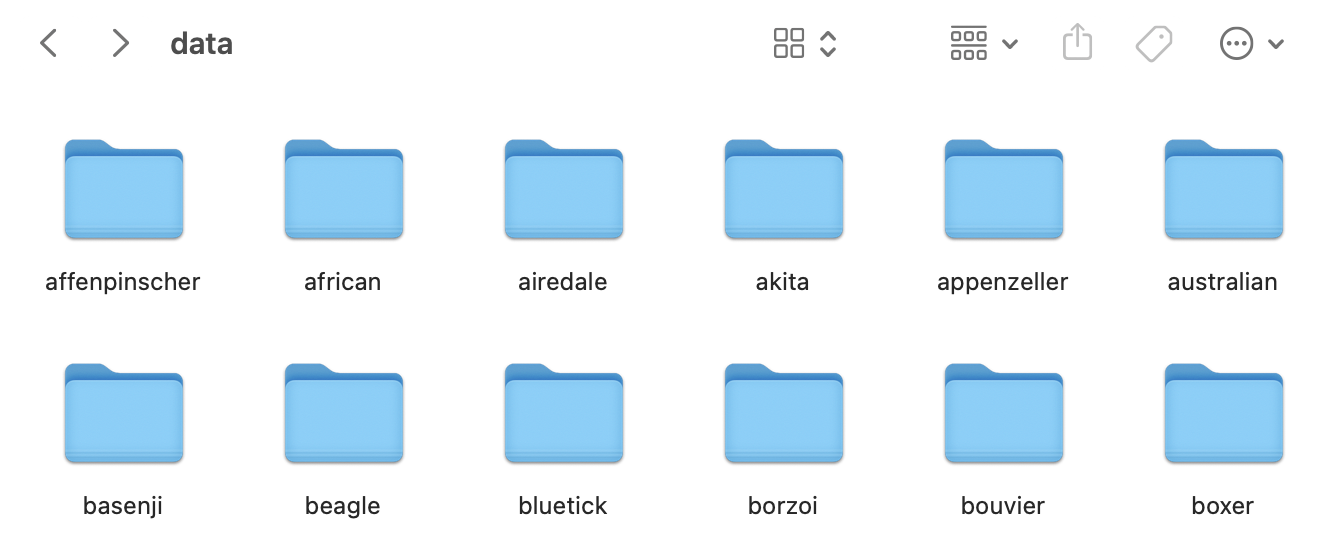
</div>

In [53]:
raw_data_path = '../data'
print('Total number of breeds in the raw dataset: ', len([i for i in os.listdir(raw_data_path)]))

Total number of breeds in the raw dataset:  91


## Dataset Preperation ##

There are in total 91 dog breeds in the raw dataset.  
However, the data sizes for each breed are varing from a dozen to more than a hundred.  
To create a balanced dataset, we have filtered **10 most popular dog breeds** out of the list and with data size **more than 100 images** .  
Below is the list of dog breeds to be classified in our classsifier.

In [79]:
# list of dog breeds to be classified in our dog classifier
dog_dict = {
    'affenpinscher':0,
    'beagle':1,
    'boxer':2,
    'chihuahua':3,
    'frenchbulldog':4,
    'goldenretriever':5,
    'rottweiler':6,
    'schnauzer':7,
    'sheepdog':8,
    'spaniel':9
}

To improve the quality of the dataset, we screen through the images and unsuitable images are removed from the dataset, e.g., images with vague objects.  
After data cleaning, the dataset is seperated into 2 sets: train set and test set with balanced class distribution.

In [80]:
print('train set size: ', train_data.size()[0])
print('test set size: ', test_data.size()[0])

train set size:  979
test set size:  100


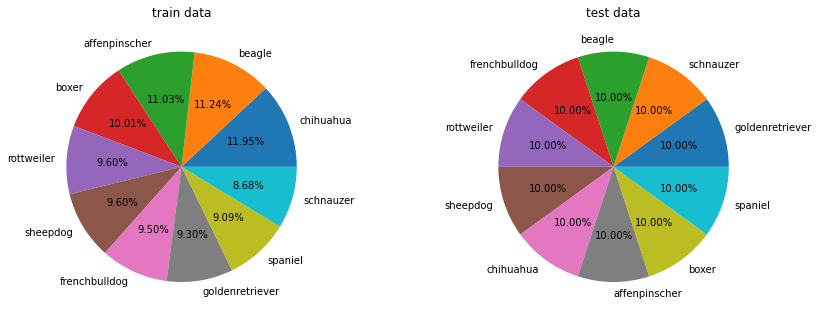

In [81]:
fig = plt.figure()

# train data class distribution
ax1 = fig.add_axes([0, 0, 1, 1], aspect=1)
plt.title("train data")
data = train_label.numpy()
data = pd.Series(data).value_counts()
label_num = data.index.tolist()
label = []
for i in range(len(label_num)):
    label.append([k for k, v in dog_dict.items() if v == label_num[i]])
label = np.asarray(label).squeeze()
ax1.pie(data, labels = label, autopct='%.2f%%')

# test data class distribution
ax2 = fig.add_axes([1, .0, 1, 1], aspect=1)
plt.title("test data")
data = test_label.numpy()
data = pd.Series(data).value_counts()
label_num = data.index.tolist()
label = []
for i in range(len(label_num)):
    label.append([k for k, v in dog_dict.items() if v == label_num[i]])
label = np.asarray(label).squeeze()
ax2.pie(data, labels = label, autopct='%.2f%%')
plt.show()

## Data Preprocessing ##

 ### Crop Images ###

Manually crop dataset images to 1:1 with clear and complete object

### Create Different Dataset with Corresponding Label ###

#### 64x64 RGB Dataset ####

In [83]:
# resize rgb data to 64x64
resize_norm = img_trans = transforms.Compose([transforms.Resize([64,64]),
                                              transforms.ToTensor()])
    
# train data
train_data = torch.Tensor([])
train_label = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img)) 
    trans_pic = resize_norm(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    train_data = torch.cat((train_data, trans_pic),0)
    
# test data
test_data = torch.Tensor([])
test_label = []
for img in os.listdir(test_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    test_label.append(pic_label)
    pic = Image.open(os.path.join(test_img_path,img)) 
    trans_pic = resize_norm(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    test_data = torch.cat((test_data, trans_pic),0)

# change label from list to tensor
train_label = torch.tensor(train_label)
test_label = torch.tensor(test_label)

# save train data and label to .pt file
torch.save(train_data, '../dog_dataset/train_data_final.pt')
torch.save(train_label, '../dog_dataset/train_label_final.pt')
torch.save(test_data, '../dog_dataset/test_data_final.pt')
torch.save(test_label, '../dog_dataset/test_label_final.pt')

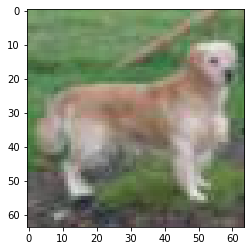

In [89]:
utils.show(train_data[4])

#### 64x64 Grayscale Dataset ####

In [84]:
# rgb to gray
rgb_to_gray = transforms.Compose([transforms.Resize([64,64]),
                                  transforms.Grayscale(num_output_channels=1),
                                  transforms.ToTensor()])

# train data
train_data_gray = torch.Tensor([])
train_label_gray = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label_gray.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img))
    pic = rgb_to_gray(pic)
    train_data_gray = torch.cat((train_data_gray, pic),0)
    
# test data
test_data_gray = torch.Tensor([])
test_label_gray = []
for img in os.listdir(test_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    test_label_gray.append(pic_label)
    pic = Image.open(os.path.join(test_img_path,img))
    pic = rgb_to_gray(pic)
    test_data_gray = torch.cat((test_data_gray, pic),0)
    
# change label from list to tensor
train_label_gray = torch.tensor(train_label_gray)
test_label_gray = torch.tensor(test_label_gray)
    
# save train data and label to .pt file
torch.save(train_data_gray, '../dog_dataset/train_data_gray.pt')
torch.save(train_label_gray, '../dog_dataset/train_label_gray.pt')
torch.save(test_data_gray, '../dog_dataset/test_data_gray.pt')
torch.save(test_label_gray, '../dog_dataset/test_label_gray.pt')

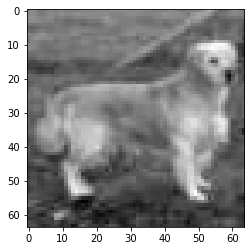

In [88]:
utils.show(train_data_gray[4])

#### 64x64 Image Augmentation ####

In [91]:
# image augmentation
img_augmentation = transforms.Compose([transforms.Resize([64,64]),
                                        transforms.RandomHorizontalFlip(),
                                        transforms.ColorJitter(brightness=0.3, contrast=0.3),
                                        transforms.ToTensor()])

#train data
train_data_aug = torch.Tensor([])
train_label_aug = []
for img in os.listdir(train_img_path):
    pic_data = []
    breed = img.split('_')[0]
    pic_label = dog_dict[breed]
    train_label_aug.append(pic_label)
    pic = Image.open(os.path.join(train_img_path,img)) 
    trans_pic = img_augmentation(pic)
    trans_pic = torch.unsqueeze(trans_pic, dim=0)
    train_data_aug = torch.cat((train_data_aug, trans_pic),0)
    
# change label from list to tensor
train_label_aug = torch.tensor(train_label_aug)

# save test data and label to .pt file
torch.save(train_data_aug, '../dog_dataset/train_data_aug.pt')
torch.save(train_label_aug, '../dog_dataset/train_label_aug.pt')

Create augmented dataset by random flip, brightness and contrast adjustment.  
(top: original data, bottom: augmented data)  
<div>
    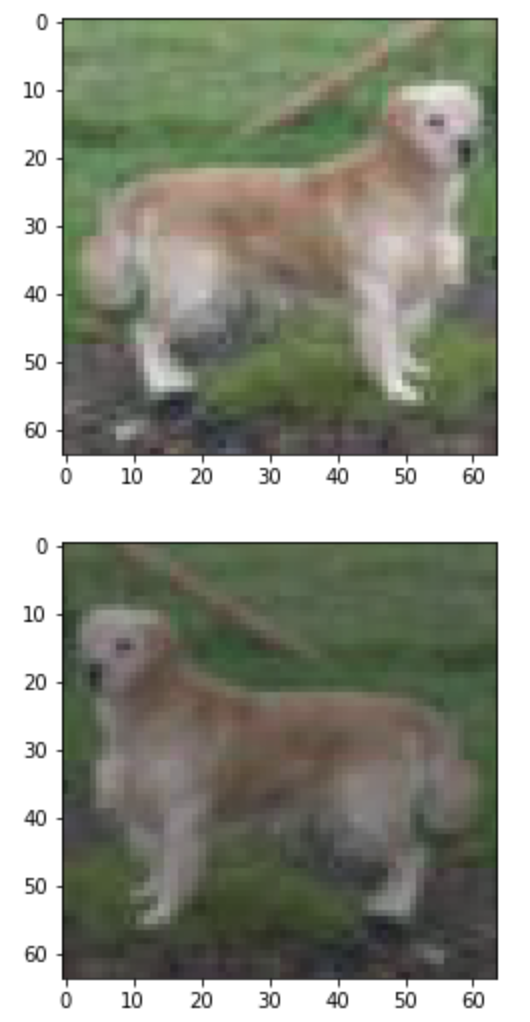
</div>